# **Subtask 1**: premise/claim classification

This Notebook contains all the code that was used for the task of premise/claim classification.

Please note that currently this notebook is setup to obtain our best results for this task. In essence, this means that we are using the following model and settings:
- **Model**: DistilBERT uncased
- **Epoch**: 5
- **Learning Rate**: 5e-6
- **Batch size**: 8

The settings, models and seeds can be easily adapted with this notebook by using the settings cellblock.

In [68]:
# making sure the transformers library is installed
!pip install transformers

In [69]:
# Use this cellblock if you are using Google Drive for the data storage
# from google.colab import drive
# drive.mount('/content/drive')

In [70]:
# Importing all needed libraries for the project
#!/usr/bin/env python

# General Data Analysis
import numpy as np
import tensorflow as tf
import random
import random as python_random
import pandas as pd
import time
import datetime
import os
from collections import defaultdict
import json

# Transformers
from transformers import (BertTokenizer,
                          DistilBertTokenizer, 
                          RobertaTokenizer, 
                          BertForSequenceClassification, 
                          AdamW, 
                          DistilBertForSequenceClassification,
                          get_linear_schedule_with_warmup)


# SKLearn
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# Torch
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns



## Settings & Seeds 

The cellblock below can be used to change the overall settings and model for the notebook.

Furthermore, this cellblock can be used to change the seed over multiple runs. When the last seed is selected from the seeds list, the averages will be calculated and stored into a seperate file.

At this current time, the notebook is set to the final seed and the results will be stored and meaned.

In [101]:
# This codeblock contains the general settings.

# List of models that we experimented with
models = ['distilbert-base-uncased', 'roberta-large', 'bert-base-uncased', 'roberta-base',
          'distilbert-base-uncased-finetuned-sst-2-english']

# Model that is used in this notebook
model_to_use = models[0] #!!! Use this variable to change the model that is used !!!#
epochs = 5
batch_size = 8
lr = 5e-6
tok_length = 200

# Set seeds for reproducibility
seeds = [42, 1234, 32, 15, 128]

#!!! Use this variable to change the seed over 5 runs !!!#
seed_to_use = seeds[4]

#!!! Use the code below to indicate when to mean all of the scores over the seeds !!!#
do_mean = False
if seed_to_use == seeds[-1]:
  print(f'Seed was set to {seed_to_use}, therefore we will mean all the scores')
  do_mean = True

np.random.seed(seed_to_use)
tf.random.set_seed(seed_to_use)
python_random.seed(seed_to_use)

# Path to output classification report
scores_path = '../data/subtask-1/classification_reports.json'


Seed was set to 128, therefore we will mean all the scores


In [72]:

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [73]:
data_path = '../data/subtask-1/'


# Loading in our train and test splits, types are formatted to numerical values
df_train = pd.read_csv(f'{data_path}df_st1_train.csv', index_col=0)
df_train['label'] = np.where(df_train['type'] == 'premise', 1, 0)

df_test = pd.read_csv(f'{data_path}df_st1_test.csv', index_col=0)
df_test['label'] = np.where(df_test['type'] == 'premise', 1, 0)


df_train.head()

,document,file_path,split,text,type,label
0,88,v2.0/positive/88.xml,positive,[47% of all jobs are at risk of being automate...,premise,1
1,88,v2.0/positive/88.xml,positive,This number will grow grow until the vast majo...,premise,1
2,88,v2.0/positive/88.xml,positive,Since some of this automation will inevitably ...,premise,1
3,88,v2.0/positive/88.xml,positive,By fortifying themselves in their gated commun...,premise,1
4,88,v2.0/positive/88.xml,positive,"Once everyone is dead, they can simply be wipe...",premise,1


In [74]:
# Generating a development set from our training data
X_train, X_dev, Y_train, Y_dev = train_test_split(df_train['text'].to_list(), 
                                                  df_train['label'].to_list(), 
                                                  test_size=0.2, 
                                                  random_state=seed_to_use)
X_test = df_test['text'].to_list()
Y_test = df_test['label'].to_list()

In [75]:
#Transform string labels to one-hot encodings
encoder = LabelBinarizer()
Y_train_bin = encoder.fit_transform(Y_train)
Y_dev_bin = encoder.fit_transform(Y_dev)
print(Y_train_bin, type(Y_train_bin))

Y_train = np.asarray([[i] for i in Y_train])
Y_dev = np.asarray([[i] for i in Y_dev])

[[1]
 [0]
 [0]
 ...
 [1]
 [0]
 [1]] <class 'numpy.ndarray'>


## Tokenization

The code blocks below are used for the tokenization of our training and development data.

In [76]:
# Tokenization loading for the model to use
distil = False
if model_to_use == 'roberta-large' or model_to_use == 'roberta-base':
  print('Loading RoBERTa tokenizer...')
  tokenizer = RobertaTokenizer.from_pretrained(model_to_use)

elif 'distilbert' in model_to_use:
  print('Loading DistilBERT tokenizer...')
  distil = True
  tokenizer = DistilBertTokenizer.from_pretrained(model_to_use)
else:
  # Load the BERT tokenizer.
  print('Loading BERT tokenizer...')
  tokenizer = BertTokenizer.from_pretrained(model_to_use)


Loading DistilBERT tokenizer...


In [77]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence
for sent in X_train:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = tok_length,          # Pad & truncate all sentences.
                        padding='max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
train_input_ids = torch.cat(input_ids, dim=0)
train_attention_masks = torch.cat(attention_masks, dim=0)
train_labels = torch.tensor(Y_train)

In [78]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for sent in X_dev:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = tok_length,    # Pad & truncate all sentences.
                        padding='max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
dev_input_ids = torch.cat(input_ids, dim=0)
dev_attention_masks = torch.cat(attention_masks, dim=0)
dev_labels = torch.tensor(Y_dev)

In [79]:
# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
dev_dataset = TensorDataset(dev_input_ids, dev_attention_masks, dev_labels)

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
        train_dataset,  # The training samples.
        sampler = SequentialSampler(train_dataset),  # Training data is already randomized
        batch_size = batch_size  # Train with this batch size.
    )

# For validation the order doesn't matter, so we'll just read them sequentially.
dev_dataloader = DataLoader(
            dev_dataset, # The validation samples.
            sampler = SequentialSampler(dev_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


## Model Creation and Setup

In [80]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
if distil:
  model = DistilBertForSequenceClassification.from_pretrained(
      model_to_use,  # Use the 12-layer BERT model, with an uncased vocab.
      num_labels = 2,                  # The number of output labels--2 for binary classification.
      output_attentions = False,       # Whether the model returns attentions weights.
      output_hidden_states = False,    # Whether the model returns all hidden-states.
  )
else:
  print('Using bert for seq clas')
  model = BertForSequenceClassification.from_pretrained(
    model_to_use,  # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2,                  # The number of output labels--2 for binary classification.
    output_attentions = False,       # Whether the model returns attentions weights.
    output_hidden_states = False,    # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
try:
    # probably only works on google Colab
    model.cuda()
except AssertionError:
    pass

# Resizes input token embeddings matrix to account for the new special tokens
model.resize_token_embeddings(len(tokenizer))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

Embedding(30522, 768, padding_idx=0)

In [81]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 104 different named parameters.

==== Embedding Layer ====

distilbert.embeddings.word_embeddings.weight            (30522, 768)
distilbert.embeddings.position_embeddings.weight          (512, 768)
distilbert.embeddings.LayerNorm.weight                        (768,)
distilbert.embeddings.LayerNorm.bias                          (768,)
distilbert.transformer.layer.0.attention.q_lin.weight     (768, 768)

==== First Transformer ====

distilbert.transformer.layer.0.attention.q_lin.bias           (768,)
distilbert.transformer.layer.0.attention.k_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.k_lin.bias           (768,)
distilbert.transformer.layer.0.attention.v_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.v_lin.bias           (768,)
distilbert.transformer.layer.0.attention.out_lin.weight   (768, 768)
distilbert.transformer.layer.0.attention.out_lin.bias         (768,)
distilbert.transformer.layer.0.sa_layer_norm.weight           (

In [82]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = lr, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/Users/folkertleistra/PycharmProjects/ltp/venv/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [83]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            # default 0
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Train

In [84]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [85]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [86]:
predictions, true_labels = defaultdict(list), defaultdict(list)
val_losses = {}

# Set the seed value all over the place to make this reproducible.
seed_val = seed_to_use

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []
    
# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains four pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        #   [3]: tweet ids
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       #token_type_ids=None,
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits
        
        # 'logits' is a 2D tensor with lists of logit lists
        # 'b_labels' is a 1D tensor of the true label
        # 'b_ids' is a 1D tensor of the tweet IDs

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.3f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in dev_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        #   [3]: tweet ids
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           #token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        true_labels[epoch_i].append(label_ids)
        predictions[epoch_i].append(logits)

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(dev_dataloader)
    print("  Accuracy: {0:.3f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(dev_dataloader)
    val_losses[epoch_i] = avg_val_loss

    # If the avg_val_loss is lower than the previous recorded, save to dict
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.3f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 1 ========
Training...
  Batch    40  of    287.    Elapsed: 0:04:42.
  Batch    80  of    287.    Elapsed: 0:09:27.
  Batch   120  of    287.    Elapsed: 0:14:13.
  Batch   160  of    287.    Elapsed: 0:18:56.
  Batch   200  of    287.    Elapsed: 0:23:40.
  Batch   240  of    287.    Elapsed: 0:28:15.
  Batch   280  of    287.    Elapsed: 0:32:48.

  Average training loss: 0.670
  Training epoch took: 0:33:30

Running Validation...
  Accuracy: 0.562
  Validation Loss: 0.654
  Validation took: 0:02:26

Training complete!
Total training took 0:35:56 (h:mm:ss)


In [88]:

# Display floats with three decimal places. (only works on colab)
#pd.set_option('precision', 3)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
print(df_stats)

best_val_loss  = min(val_losses, key=val_losses. get)
print(best_val_loss)

       Training Loss  Valid. Loss  Valid. Accur. Training Time Validation Time
epoch                                                                         
1           0.669644     0.653753       0.562153       0:33:30         0:02:26
0


([<matplotlib.axis.XTick at 0x168ac11f0>], [Text(0, 0, '')])

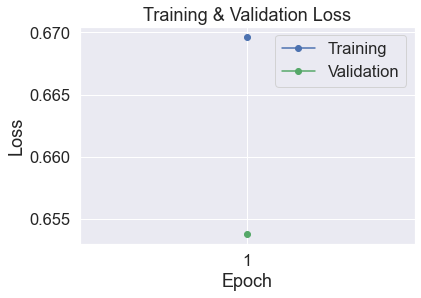

In [89]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(list(range(1, epochs + 1)))

#plt.show()


In [90]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions[best_val_loss], axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels[best_val_loss], axis=0)

In [91]:
print(classification_report(flat_true_labels, flat_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       251
           1     0.5620    1.0000    0.7196       322

    accuracy                         0.5620       573
   macro avg     0.2810    0.5000    0.3598       573
weighted avg     0.3158    0.5620    0.4044       573



/Users/folkertleistra/PycharmProjects/ltp/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/folkertleistra/PycharmProjects/ltp/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/folkertleistra/PycharmProjects/ltp/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [92]:
class_dict = classification_report(flat_true_labels, flat_predictions, digits=2, output_dict=True)
class_dict

/Users/folkertleistra/PycharmProjects/ltp/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/folkertleistra/PycharmProjects/ltp/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/folkertleistra/PycharmProjects/ltp/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 251},
 '1': {'precision': 0.5619546247818499,
  'recall': 1.0,
  'f1-score': 0.7195530726256983,
  'support': 322},
 'accuracy': 0.5619546247818499,
 'macro avg': {'precision': 0.28097731239092494,
  'recall': 0.5,
  'f1-score': 0.35977653631284917,
  'support': 573},
 'weighted avg': {'precision': 0.3157930003137097,
  'recall': 0.5619546247818499,
  'f1-score': 0.4043561769380015,
  'support': 573}}

In [107]:
d_keys = class_dict.keys()

if os.path.exists(scores_path):
  print('Appending to existing scores')
  # Loading the data we already stored
  with open(scores_path, 'r') as fp:
    stored_data = json.load(fp)
  
  seed_error = False
  if seed_to_use in stored_data['seeds']:
    print('ERROR: seed was already used please make sure to change the seed_to_use variable.')
    seed_error = True

  if not seed_error:
    print('Processing stored data')
    for k in d_keys:
      if k != 'accuracy':
        stored_data[k]['f1-score'] += [class_dict[k]['f1-score']]
        stored_data[k]['precision'] += [class_dict[k]['precision']]
        stored_data[k]['recall'] += [class_dict[k]['recall']]
        stored_data[k]['support'] += [class_dict[k]['support']]

      else:
        stored_data[k] += [class_dict[k]]
    
    stored_data['seeds'] += [seed_to_use]
      
    # Storing values into a seperate json file
    with open(scores_path, "w") as fp:
      json.dump(stored_data, fp)
  

else:
  print('Storing for the first time')
  
  # Have to perform some pre-processing
  processed_dict = dict()
  for k in d_keys:
    if k != 'accuracy':
      processed_dict[k] = {'f1-score': [class_dict[k]['f1-score']],
                           'precision': [class_dict[k]['precision']],
                           'recall': [class_dict[k]['recall']],
                           'support': [class_dict[k]['support']]} 
    else:
      processed_dict[k] = [class_dict[k]]
  
  processed_dict['seeds'] = [seed_to_use]
  
  # Storing values into a seperate json file
  with open(scores_path, "w") as fp:
    json.dump(processed_dict, fp)


Appending to existing scores
ERROR: seed was already used please make sure to change the seed_to_use variable.


In [113]:
# This cell will execute when do_mean is set to True
d_keys = class_dict.keys()
if do_mean:
  print('Performing meaning of the classification reports')
  # Loading the data we already stored
  with open(scores_path, 'r') as fp:
    final_data = json.load(fp)

  final_class_dict = dict()
  for k in d_keys:
    if k != 'accuracy':
      final_data[k] = {'f1-score': [np.array(final_data[k]['f1-score']).mean(), np.array(final_data[k]['f1-score']).std()],
                       'precision': [np.array(final_data[k]['precision']).mean(), np.array(final_data[k]['precision']).std()],
                       'recall': [np.array(final_data[k]['recall']).mean(), np.array(final_data[k]['recall']).std()],
                        'support': [np.array(final_data[k]['support']).mean(), np.array(final_data[k]['support']).std()]
                       } 
    else:
      final_data[k] = [np.array(final_data[k]).mean(), np.array(final_data[k]).std()]


  final_scores_path = '../data/subtask-1/FINAL_classification_report.json'
  # Storing values into a seperate json file
  with open(f'{final_scores_path}', "w") as fp:
    json.dump(final_data, fp)

Performing meaning of the classification reports


In [114]:
final_data

{'0': {'f1-score': [0.0, 0.0],
  'precision': [0.0, 0.0],
  'recall': [0.0, 0.0],
  'support': [251.0, 0.0]},
 '1': {'f1-score': [0.7195530726256983, 0.0],
  'precision': [0.5619546247818499, 0.0],
  'recall': [1.0, 0.0],
  'support': [322.0, 0.0]},
 'accuracy': [0.5619546247818499, 0.0],
 'macro avg': {'f1-score': [0.35977653631284917, 0.0],
  'precision': [0.28097731239092494, 0.0],
  'recall': [0.5, 0.0],
  'support': [573.0, 0.0]},
 'weighted avg': {'f1-score': [0.4043561769380015, 0.0],
  'precision': [0.3157930003137097, 0.0],
  'recall': [0.5619546247818499, 0.0],
  'support': [573.0, 0.0]},
 'seeds': [128]}